In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from ucimlrepo import fetch_ucirepo
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import utils_data as u
from sklearn.preprocessing import StandardScaler

In [3]:
dataset_filename = Path('./steel_industry_energy_consumption.parquet')
if dataset_filename.exists():
    df = pd.read_parquet(dataset_filename)
else:
    # fetch dataset
    steel_industry_energy_consumption = fetch_ucirepo(id=851)
    df = pd.DataFrame(steel_industry_energy_consumption.data.original)
    df.to_parquet('steel_industry_energy_consumption.parquet')

In [4]:
df.sample(n=9)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
30449,14/11/2018 04:30,3.67,6.26,0.00,0.00,50.58,100.00,16200,Weekday,Wednesday,Light_Load
32373,04/12/2018 05:30,5.44,5.29,0.00,0.00,71.69,100.00,19800,Weekday,Tuesday,Light_Load
23133,29/08/2018 23:30,2.88,4.50,0.00,0.00,53.91,100.00,84600,Weekday,Wednesday,Light_Load
21120,09/08/2018 00:15,3.17,4.68,0.00,0.00,56.08,100.00,900,Weekday,Thursday,Light_Load
659,07/01/2018 21:00,3.60,0.00,16.92,0.00,100.00,20.81,75600,Weekend,Sunday,Light_Load
24875,17/09/2018 03:00,2.74,5.44,0.00,0.00,44.98,100.00,10800,Weekday,Monday,Light_Load
15073,07/06/2018 00:30,2.99,5.76,0.00,0.00,46.07,100.00,1800,Weekday,Thursday,Light_Load
15163,07/06/2018 23:00,3.42,4.86,0.00,0.00,57.55,100.00,82800,Weekday,Thursday,Medium_Load
9656,11/04/2018 14:15,49.90,19.76,0.00,0.02,92.98,100.00,51300,Weekday,Wednesday,Maximum_Load


In [5]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')

In [6]:
# Hacemos una diferenciación entre fines de semana y días hábiles
df['IsWeekend'] = df['WeekStatus'] == 'Weekend'
df.drop(['WeekStatus'], axis=1, inplace=True)

In [7]:
# Utilizamos One Hot Enconder eliminando las columnas iniciales
df = pd.get_dummies(df, columns=["Day_of_week", "Load_Type"], drop_first=True)

In [8]:
# Crear nuevas columnas descomponiendo la fecha y hora en sus componentes
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['second'] = df['date'].dt.second
df['dayofweek'] = df['date'].dt.dayofweek  # Lunes=0, Domingo=6
df['dayofyear'] = df['date'].dt.dayofyear
df['weekofyear'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter

In [9]:
df.drop(["year", "second", "date"], axis=1, inplace=True) # No tienen variabilidad

In [10]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled_ = pd.DataFrame(df_scaled, columns=df.columns) 

In [11]:
y = df_scaled_['Usage_kWh']
X = df_scaled_.drop(['Usage_kWh'], axis=1)

In [12]:
dataset_filename = Path('./steel_industry_energy_consumption_features_importances.parquet')
if dataset_filename.exists():
    df_features_importances = pd.read_parquet(dataset_filename)
else:
    data = u.DataFeaturesImportances(X, y)
    df_features_importances = data.get_feature_importance_matrix()
    df_features_importances.to_parquet('steel_industry_energy_consumption_features_importances.parquet')

In [ ]:
# df_features_importances.sort_values(by=['XGBoost'], ascending=False)

In [ ]:
# df_features_importances[["Feature","Random Forest"]]

<Axes: >

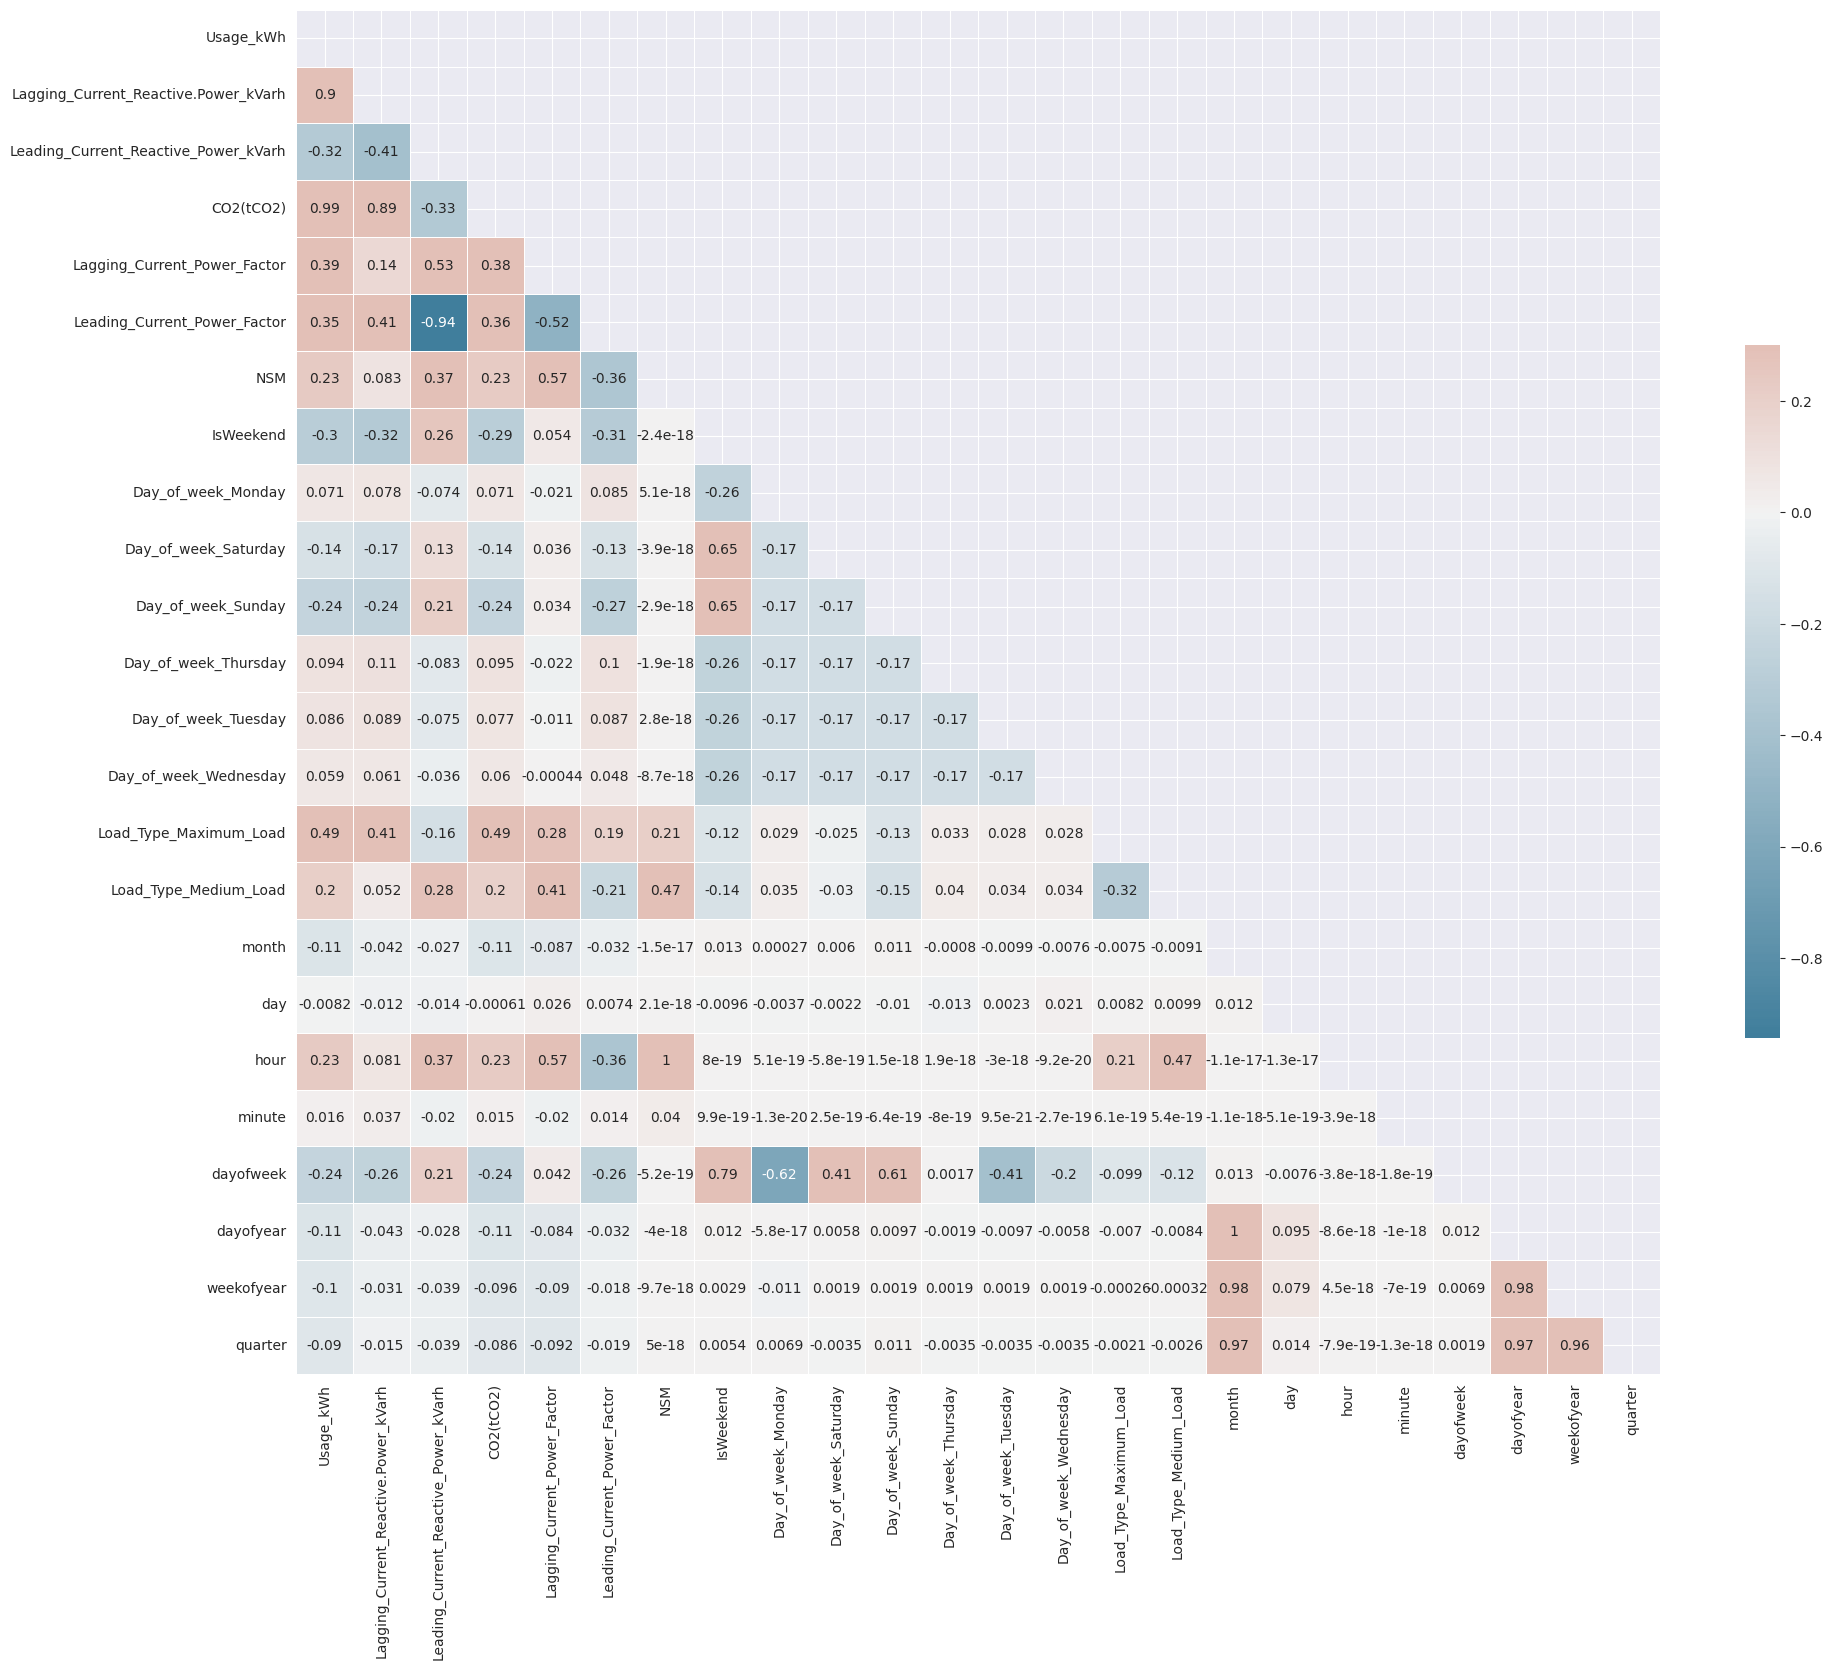

In [13]:
corr = df_scaled_.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
df_features_importances

,Feature,Random Forest,RF Permutation,Lasso,XGBoost
0,Lagging_Current_Reactive.Power_kVarh,0.015598,1.081394e+00,0.162060,0.009796
1,Leading_Current_Reactive_Power_kVarh,0.000408,2.505255e-03,0.003436,0.000754
2,CO2(tCO2),0.975624,9.568454e-01,0.788400,0.975790
3,Lagging_Current_Power_Factor,0.005046,7.529174e-02,0.067376,0.002312
4,Leading_Current_Power_Factor,0.001288,9.094443e-03,0.043368,0.003778
5,NSM,0.000861,4.316517e-03,-0.000130,0.001005
6,IsWeekend,0.000042,1.756114e-05,0.000076,0.001764
7,Day_of_week_Monday,0.000010,2.822544e-07,-0.000185,0.000172
8,Day_of_week_Saturday,0.000009,1.303707e-06,0.000000,0.000112
9,Day_of_week_Sunday,0.000004,1.691149e-06,0.002702,0.000050


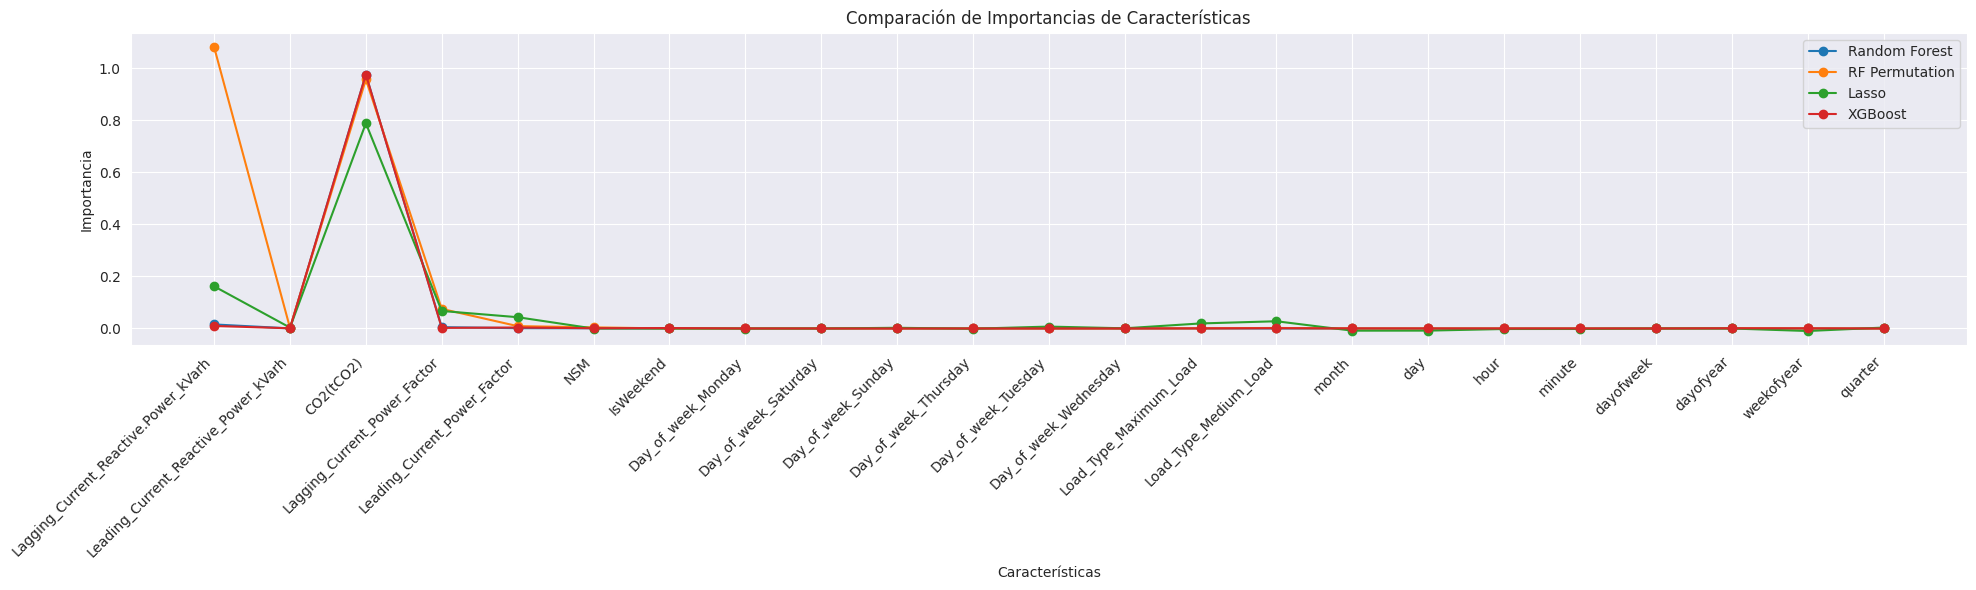

In [15]:
# Configuración de la gráfica
plt.figure(figsize=(20, 6))

# Iterar sobre las columnas excepto 'Feature'
for column in df_features_importances.columns[1:]:
    plt.plot(df_features_importances['Feature'], df_features_importances[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
#plt.ylim(-1, 2)
#plt.yticks(np.arange(-1, 1, 0.5))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Veamos como aporta los campos que creamos a partir de "date"

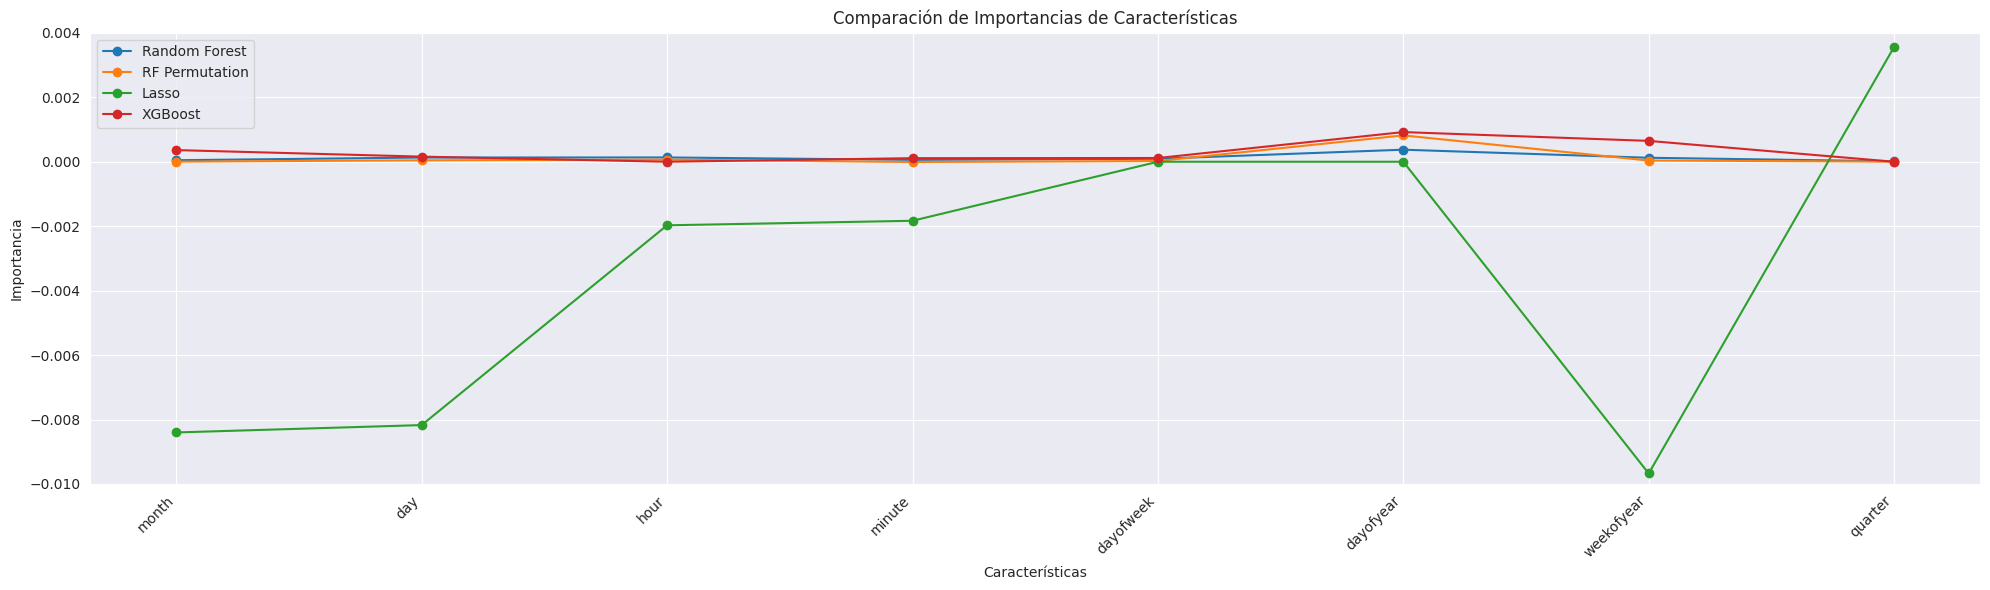

In [16]:
df_filtered = df_features_importances[df_features_importances['Feature'].isin(['month', 'day', 'hour', 'minute', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter'])]

# Configuración de la gráfica
plt.figure(figsize=(20, 6))

# Iterar sobre las columnas excepto 'Feature'
for column in df_filtered.columns[1:]:
    plt.plot(df_filtered['Feature'], df_filtered[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
plt.ylim(-0.01, 0.004)
#plt.yticks(np.arange(-0.01, 0.004, 0.00025))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Veamos como aportan los campos del dataset

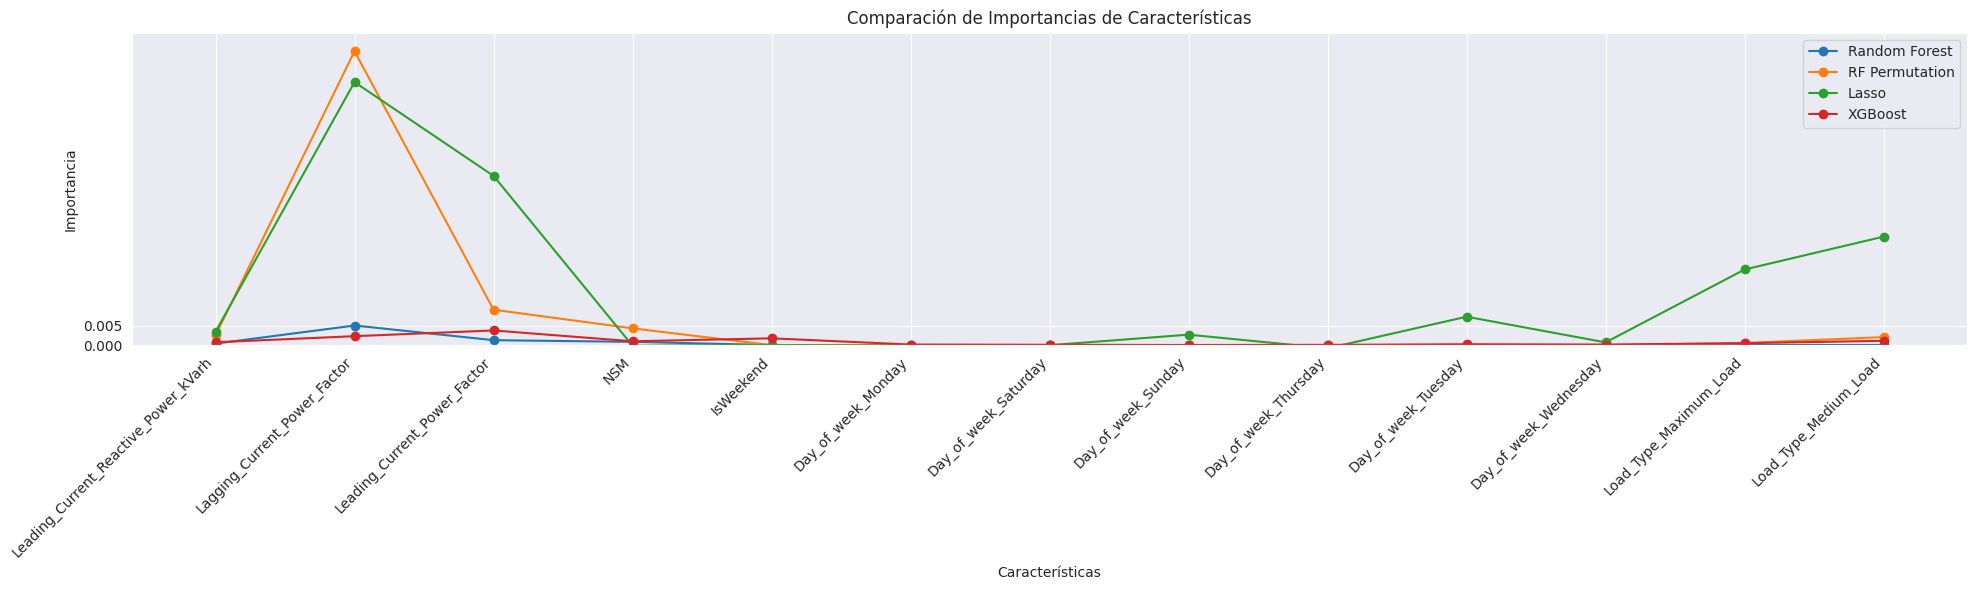

In [18]:
df_filtered = df_features_importances[df_features_importances['Feature'].isin( ['Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'IsWeekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Load_Type_Maximum_Load', 'Load_Type_Medium_Load'])]

# Configuración de la gráfica
plt.figure(figsize=(20, 6))

# Iterar sobre las columnas excepto 'Feature'
for column in df_filtered.columns[1:]:
    plt.plot(df_filtered['Feature'], df_filtered[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
plt.ylim(0, 0.08)
plt.yticks(np.arange(0, 0.01, 0.005))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## Del gráfico anterior enfocamos los que son pequeños

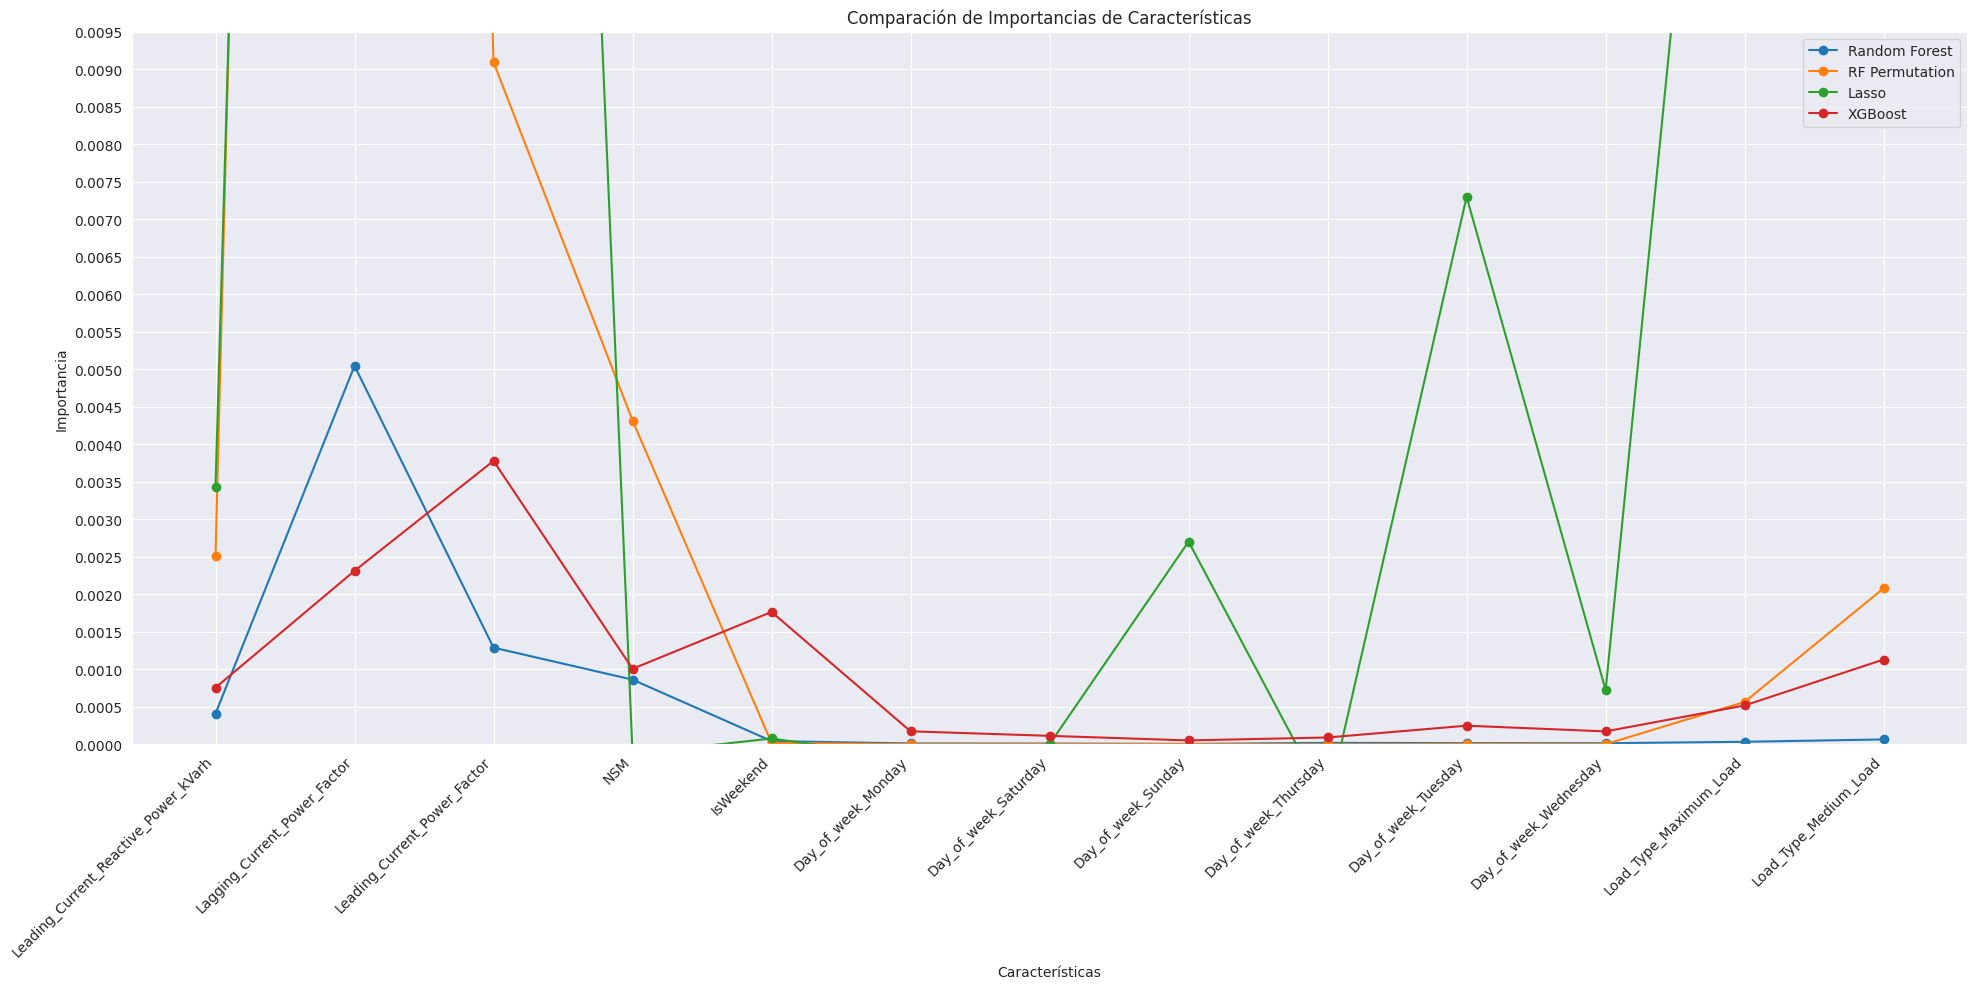

In [19]:
df_filtered = df_features_importances[df_features_importances['Feature'].isin( ['Leading_Current_Reactive_Power_kVarh', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'IsWeekend', 'Day_of_week_Monday', 'Day_of_week_Saturday', 'Day_of_week_Sunday', 'Day_of_week_Thursday', 'Day_of_week_Tuesday', 'Day_of_week_Wednesday', 'Load_Type_Maximum_Load', 'Load_Type_Medium_Load'])]

# Configuración de la gráfica
plt.figure(figsize=(20, 10))

# Iterar sobre las columnas excepto 'Feature'
for column in df_filtered.columns[1:]:
    plt.plot(df_filtered['Feature'], df_filtered[column], marker='o', label=column)

# Configuración del gráfico
plt.title('Comparación de Importancias de Características')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right')

# Ajustar el alcance del eje y y los ticks
plt.ylim(0, 0.005)
plt.yticks(np.arange(0, 0.01, 0.0005))

plt.legend()
plt.tight_layout()

# Mostrar el gráfico
plt.show()

## La data generada a partir de "date" no aporta a la variable objetivo, como se visualizó en el EDA, y ahora como se visualiza en el análisis de Feature Importances, por lo tanto será eliminada y no será parte del análisis.  

### Ver resultados BORUTA en: "Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city"

V E, S., Shin, C., & Cho, Y. (2020). Efficient energy consumption prediction model for a data analytic-enabled industry building in a smart city. Building Research & Information, 49(1), 127–143. https://doi.org/10.1080/09613218.2020.1809983


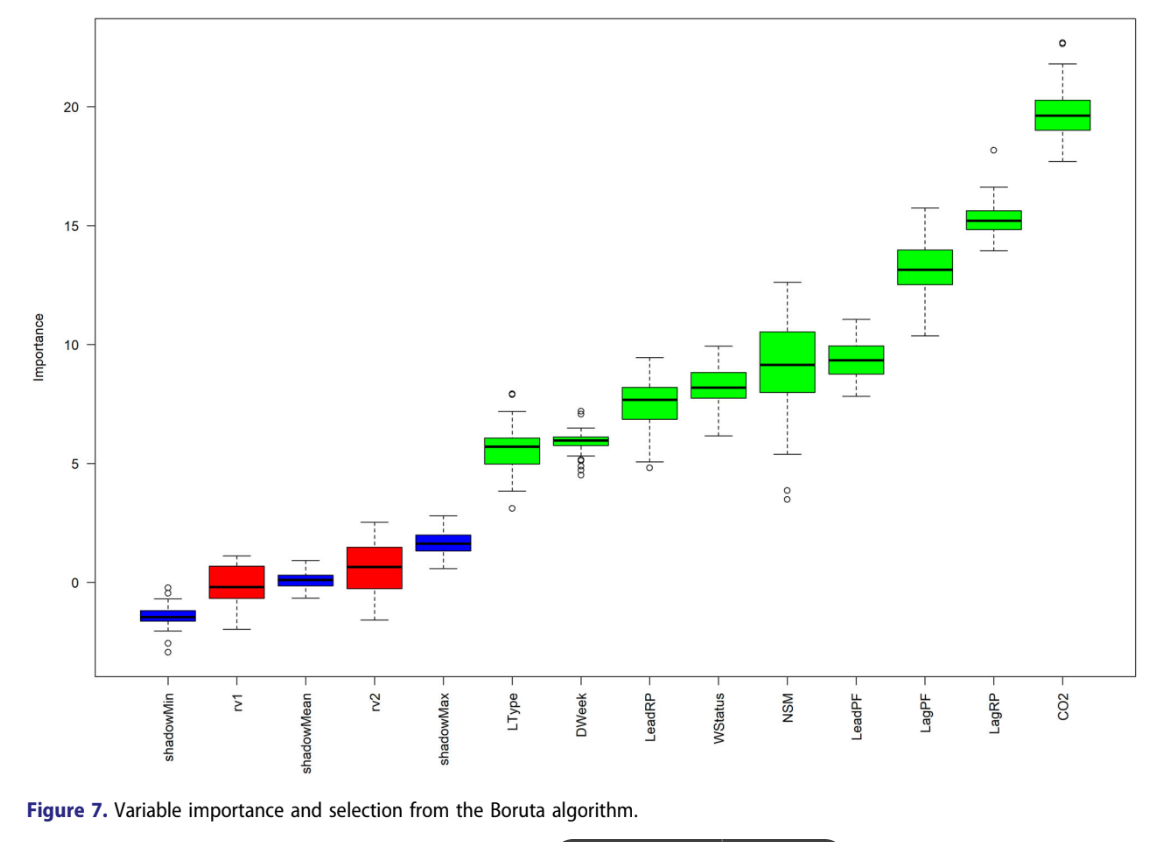

In [20]:
from IPython.display import Image, display

# Especificar la ruta de la imagen
image_path = 'referencia-boruta.png'

# Cargar y mostrar la imagen
display(Image(filename=image_path))


In [21]:
df = pd.read_parquet('steel_industry_energy_consumption.parquet')

In [23]:
df.drop(["date"], axis=1, inplace=True)
df['IsWeekend'] = df['WeekStatus'] == 'Weekend'
df.drop(['WeekStatus'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=["Day_of_week", "Load_Type"], drop_first=True)

In [24]:
df.columns.to_list()

['Usage_kWh',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor',
 'NSM',
 'IsWeekend',
 'Day_of_week_Monday',
 'Day_of_week_Saturday',
 'Day_of_week_Sunday',
 'Day_of_week_Thursday',
 'Day_of_week_Tuesday',
 'Day_of_week_Wednesday',
 'Load_Type_Maximum_Load',
 'Load_Type_Medium_Load']

In [25]:
df.to_parquet('dataset-steel.parquet')